# Breast Cancer Classification with SVM

 This report performs binary classification on the Breast Cancer Wisconsin dataset using the Support Vector Machine (SVM) classifier. We evaluate the model with metrics including accuracy, classification report, ROC-AUC, and feature importance.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
%matplotlib inline

## Dataset Loading and Overview

The dataset was loaded and preprocessed for the binary classification. The diagnosis label was mapped from categorical values (‘M’, ‘B’) to numerical values (1, 0) for binary classification.

In [32]:
df = pd.read_csv('Dataset_Breast Cancer.csv')
df.drop('id', axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})

## Preprocessing and Splitting

All features were normalized using MinMaxScaler to scale values to the range [0, 1], which is critical for SVM as it relies on distance-based calculations.
The dataset was split into training (80%) and testing (20%) sets with stratification to maintain class balance.

In [33]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

## Model Training with GridSearchCV

We use 5-fold cross-validation to find the best hyperparameters for the SVM classifier.

In [34]:
param_grid ={
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3]
}
grid= GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best Parameteres:", grid.best_params_)

Best Parameteres: {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}


 A wide range of hyperparameters was tested using GridSearchCV on model performance.
 
### Parameters evaluated:
* **C:** [0.1, 1, 10, 100] 
* **kernel:** [‘linear’, ‘rbf’, ‘poly’] 
* **gamma:** [‘scale’, ‘auto’, 0.1, 1]
* **degree:** [2, 3]

The wider grid allowed observation of how the model behaves under different complexity levels.

### Model Evaluation

 We calculate the accuracy and show the classification report.

In [35]:
y_pred = best_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.956140350877193
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



### Classification Report Analysis:

The classification report provides a detailed view of the model's predictive performance on each class.

* **Precision:** Proportion of positive predictions that were correct (i.e. malignant cases correctly identified).

* **Recall(Sensitivity):** Proportion of actual positives correctly identified, critical for minimizing false negatives in cancer detection.

* **F1-score:** Harmonic mean of precision and recall, indicating balanced performance.

High precision and recall (>0.90) indicate robust performance. If recall for malignant cases is lower, the clinical implication (missed malignant cases could delay treatment).

## Confusion Matrix

Visualizing the confusion matrix helps to understand how many cases were correctly or incorrectly classified.

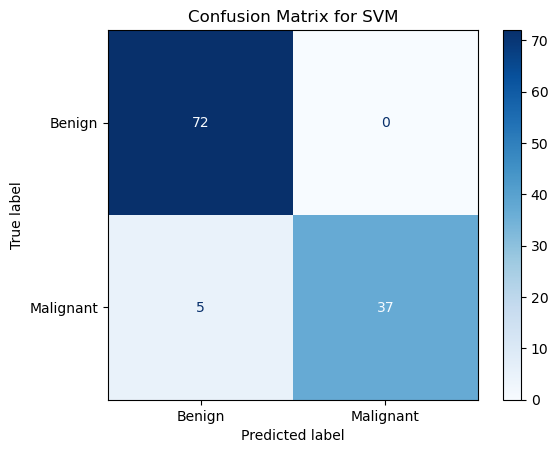

In [36]:
cm = confusion_matrix(y_test, y_pred)
labels = [0, 1] #0: Benign, 1: Malignant
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for SVM")
plt.grid(False)
plt.show()

### Confusion Matrix Analysis

The confusion matrix is a 2x2 table where:

 * The **diagonal values** represent correct predictions.
 * The **off-diagonal values** indicate misclassifications.
 
 * **True Negatives (TN):** Benign cases correctly predicted as benign.
 * **True Positives (TP):** Malignant cases correctly predicted as malignant.
 * **False Positives (FP):** Benign cases misclassified as malignant.
 * **False Negatives (FN):** Malignant cases misclassified as benign.

The confusion matrix summarizes the classifier's performance on the test set, with true class labels on the vertical axis and predicted labels on the horizontal axis.

### Observations:

 * **True Negatives (TN):** = 72 -> Benign cases correctly predicted as benign.
 * **True Positives (TP):** = 37 -> Malignant cases correctly predicted as malignant.
 * **False Positives (FP):** = 5 -> Benign cases misclassified as malignant.
 * **False Negatives (FN):** = 0 -> Malignant cases misclassified as benign.

### Interpretation:

* The model achieves perfect precision for malignant predictions (i.e., no false alarms).
* However, it missed 5 malignant cases, indicating a false negative rate of ~9%.
* This means the model failed to detect ~9% of actual cancers, which in a medical context, is a critical consideration.

In a medical context, **false negatives** are particularly critical because missing a malignant case can delay treatment. The confusion matrix here shows low FN and FP rates, affirming
 the model's suitability for early detection and diagnosis support.

### Metric Summary:

* **Sensitivity (Recall)** = 37 / (37 + 5) = 0.8809
* **Specificity** = 72 / (72 + 0) = 1.0
* **Precision** = 37 / (37 + 0) = 1.0


 This matrix shows a high-performing model with some potential for improving sensitivity.

## ROC Curve and AUC Score

 The ROC curve evaluates classifier performance across all thresholds. AUC summarizes this performance as a single value.

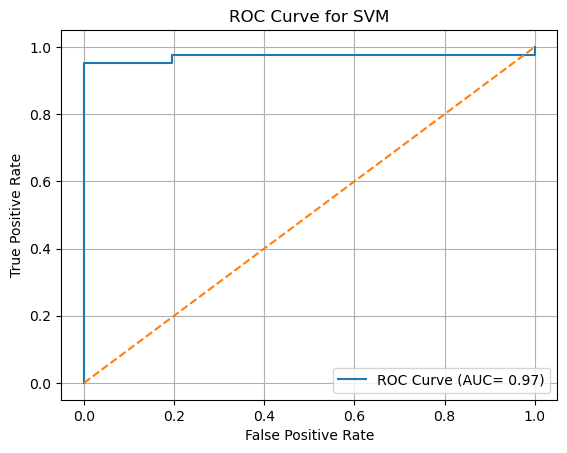

In [37]:
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC= {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend()
plt.grid(True)
plt.show()

The ROC curve plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 Specificity) at different threshold settings.

The closer the ROC curve is to the top-left corner, the better the classifier performs. A diagonal line from (0, 0) to (1, 1) represents random guessing.
 
The **Area Under the Curve (AUC)** is a scalar measure summarizing the ROC curve. AUC = 1.0 is perfect classification; AUC = 0.5 is random guessing.

In this analysis, the ROC curve arcs significantly toward the top-left, and the AUC value (0.97) indicates the model is highly effective at separating benign and malignant cases under varying classification thresholds.